## License Information
---

This file is distributed as part of `hvsrpy`, a Python package for horizontal-to-vertical spectral ratio processing.

    Copyright (C) 2019-2020 Joseph P. Vantassel (jvantassel@utexas.edu)

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https: //www.gnu.org/licenses/>.
    
## About _hvsrpy_ and this notebook
---

`hvsrpy` is a Python package for performing horizontal-to-vertical spectral ratio
(H/V) processing. `hvsrpy` was developed by Joseph P. Vantassel  with
contributions from Dana M. Brannon under the supervision
of Professor Brady R. Cox at The University of Texas at Austin.

If you use `hvsrpy` in your research or consulting, we ask you please cite the following:

>Joseph Vantassel. (2020). jpvantassel/hvsrpy: latest (Concept). Zenodo.
[http://doi.org/10.5281/zenodo.3666956](http://doi.org/10.5281/zenodo.3666956)

_Note: For software, version specific citations should be preferred to
general concept citations, such as that listed above. To generate a version
specific citation for `hvsrpy`, please use the citation tool on the `hvsrpy`
[archive](http://doi.org/10.5281/zenodo.3666956)._

The statistical calculations to consider azimuthal variability included in `hvsrpy` and
showcased in this notebook were developed by Tianjian Cheng under the supervision of
Professor Brady R. Cox at The University of Texas at Austin and are detailed in
Cheng et al (2020). To recognize their original work please cite the follwing:

> Cheng, T., Cox, B. R., Vantassel, J. P., and Manuel, L. (2020). "A statistical approach to account for azimuthal variability in single-station HVSR measurements." Geophysical Journal International, https://doi.org/10.1093/gji/ggaa342


## Getting Started
---
1. Install `hvsrpy` and its dependencies, with `pip install hvsrpy`. If you are not familiar with `pip`, a useful tutorial can be found [here](https://jpvantassel.github.io/python3-course/#/intro/pip). __(~3 minutes)__
2. Try analyzing the four provided examples. The names of these files have been written and commented out in the section _Time Domain Settings_ for your convenience. __(~15 minutes)__
3. Try one of your own _miniseed_ files. Note that the azimuthal calculation performed as part of `hvsrpy` is different from that implemented in Geopsy, so while you should expect the two programs to be consistent you should not expect them to be identical. If you get an error related to the _miniseed_ file this likely means it does not conform to the _SEED_ standard (refer to the [hvsrpy documentation](https://hvsrpy.readthedocs.io/en/stable/) for details). __(~15 minutes)__

Happy Processing!

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

import hvsrpy

## Time Domain Settings
---

In [2]:
# Input file name (may be a relative or full path).
# file_name = "UT.STN11.A2_C50.miniseed"
file_name = "UT.STN11.A2_C150.miniseed"
# file_name = "UT.STN12.A2_C50.miniseed"
# file_name = "UT.STN12.A2_C150.miniseed"

# Window length in seconds. In general low frequency peaks require longer window lengths.
# See the SESAME guidelines for specific window length recommendations.
windowlength = 60

# Boolean to control whether Butterworth filter is applied. 
# Geopsy does not apply a bandpass filter.
filter_bool = False        
# Low-cut frequency for bandpass filter.
flow = 0.1                   
# High-cut frequency for bandpass filter.
fhigh = 30                   
# Filter order.
forder = 5

# Width of cosine taper {0. - 1.}. Geopsy default of 0.05 is equal to 0.1 -> 0.1 is recommended
width = 0.1

## Frequency Domain Settings
---

In [3]:
# Konno and Ohmachi smoothing constant. 40 is recommended.
bandwidth = 40

# Minimum frequency after resampling
minf = 0.2    
# Maximum frequency after resampling
maxf = 20
# Number of frequencies after resampling
nf = 128
# Type of resampling {'log', 'linear'}
res_type = 'log'

## H/V Settings
---

In [4]:
# Rotation of horizontal components
# azimuthal_inverval defines the spacing in degrees between considerd azimuths -> 15 is recommended.
azimuthal_interval = 15
azimuth = np.arange(0, 180, azimuthal_interval)

# Boolean to control whether frequency-domain rejection-rejection algorithm is applied.
# Geopsy does not offer this functionality.
rejection_bool = True
# Number of standard deviations to consider during rejection. Smaller values will reject more windows -> 2 is recommended.
n = 2
# Maximum number of iterations to perform for rejection -> 50 is recommended.
n_iteration = 50

# Distribution of f0 {"log-normal", "normal"}. Geopsy default "normal" -> "log-normal" is recommended.
distribution_f0 = "log-normal"
# Distribution of mean curve {"log-normal", "normal"}. Geopsy default "log-normal" -> "log-normal" is recommended.
distribution_mc = "log-normal"

## Perform Calculation
---

Elapsed Time: 2.79 seconds

Statistics after rejection considering azimuth:


,Lognormal Median,Lognormal Standard Deviation
"Fundamental Site Frequency, f0,AZ",0.68,0.18
"Fundamental Site Period, T0,AZ",1.48,0.18


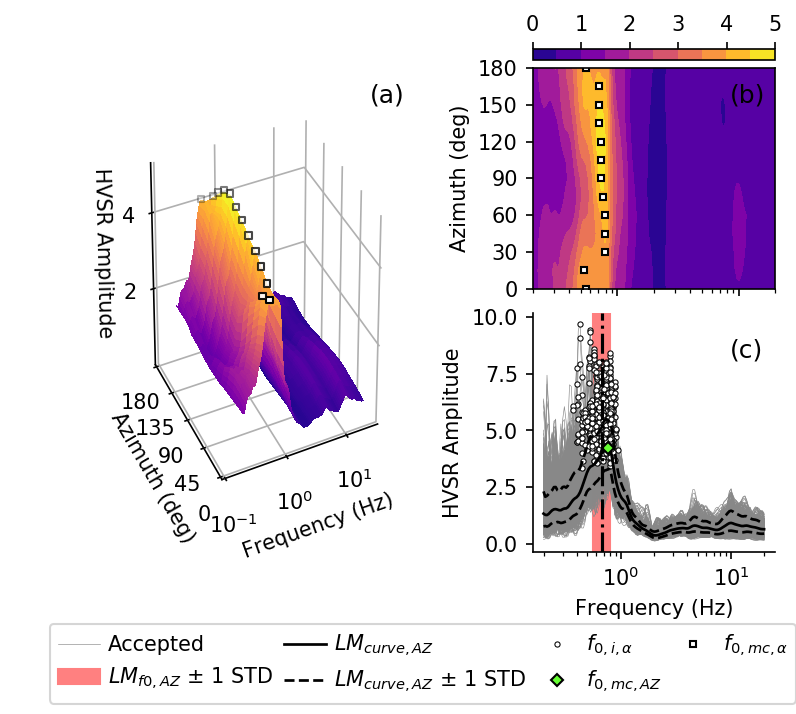

In [5]:
start = time.time()
sensor = hvsrpy.Sensor3c.from_mseed(file_name)
bp_filter = {"flag":filter_bool, "flow":flow, "fhigh":fhigh, "order":forder}
resampling = {"minf":minf, "maxf":maxf, "nf":nf, "res_type":res_type}
hv = sensor.hv(windowlength, bp_filter, width, bandwidth, resampling, "multiple-azimuths", azimuth=azimuth)

if rejection_bool:
    hv.reject_windows(n=n, max_iterations=n_iteration, distribution_f0=distribution_f0, distribution_mc=distribution_mc)

azimuths = [*hv.azimuths, 180.]
mesh_frq, mesh_azi = np.meshgrid(hv.frq, azimuths)
mesh_amp = hv.mean_curves(distribution=distribution_mc)
mesh_amp = np.vstack((mesh_amp, mesh_amp[0]))

end = time.time()
print(f"Elapsed Time: {str(end-start)[0:4]} seconds")

# Layout
fig = plt.figure(figsize=(6,5), dpi=150)
gs = fig.add_gridspec(nrows=2, ncols=2, wspace=0.3, hspace=0.1, width_ratios=(1.2,0.8))
ax0 = fig.add_subplot(gs[0:2, 0:1], projection='3d')
ax1 = fig.add_subplot(gs[0:1, 1:2])
ax2 = fig.add_subplot(gs[1:2, 1:2])
fig.subplots_adjust(bottom=0.21) 

# Settings
individual_width = 0.3
median_width = 1.3

## 3D Median Curve
ax = ax0
ax.plot_surface(np.log10(mesh_frq), mesh_azi, mesh_amp, rstride=1, cstride=1, cmap=cm.plasma, linewidth=0, antialiased=False)
for coord in list("xyz"):
    getattr(ax, f"w_{coord}axis").set_pane_color((1, 1,1))    
ax.set_xticks(np.log10(np.array([0.01, 0.1, 1, 10, 100])))
ax.set_xticklabels(["$10^{"+str(x)+"}$" for x in range(-2, 3)])
ax.set_xlim(np.log10((0.1, 30)))
ax.view_init(elev=30, azim=245)
ax.dist=12
ax.set_yticks(np.arange(0,180+45, 45))
ax.set_ylim(0,180)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Azimuth (deg)")
ax.set_zlabel("HVSR Amplitude")
pfrqs, pamps = hv.mean_curves_peak(distribution=distribution_mc)
pfrqs = np.array([*pfrqs, pfrqs[0]])
pamps = np.array([*pamps, pamps[0]])
ax.scatter(np.log10(pfrqs), azimuths, pamps*1.01, marker="s", c="w", edgecolors="k", s=9)

## 2D Median Curve
ax = ax1
contour = ax.contourf(mesh_frq, mesh_azi, mesh_amp, cmap=cm.plasma, levels=10)
ax.set_xscale("log")
ax.set_xticklabels([])
ax.set_ylabel("Azimuth (deg)")
ax.set_yticks(np.arange(0,180+30, 30))
ax.set_ylim(0,180)
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="5%", pad=0.05)
fig.colorbar(contour, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("top")

ax.plot(pfrqs, azimuths, marker="s", color="w", linestyle="", markersize=3, markeredgecolor="k",
        label=r"$f_{0,mc,\alpha}$")

## 2D Median Curve
ax = ax2

# Accepted Windows
label="Accepted"
for amps in hv.amp:
    for amp in amps:
        ax.plot(hv.frq, amp, color="#888888", linewidth=individual_width, zorder=2, label=label)
        label=None

# Mean Curve
label = r"$LM_{curve,AZ}$" if distribution_mc=="log-normal" else r"$Mean_{curve,AZ}$"
ax.plot(hv.frq, hv.mean_curve(distribution_mc), color='k', label=label, linewidth=median_width, zorder=4)

# Mean +/- Curve
label = r"$LM_{curve,AZ}$"+" ± 1 STD" if distribution_mc=="log-normal" else r"$Mean_{curve,AZ}$"+" ± 1 STD"
ax.plot(hv.frq, hv.nstd_curve(-1, distribution=distribution_mc), color="k", linestyle="--",
        linewidth=median_width, zorder=4, label=label)
ax.plot(hv.frq, hv.nstd_curve(+1, distribution=distribution_mc), color="k", linestyle="--",
        linewidth=median_width, zorder=4)

# Window Peaks
label = r"$f_{0,i,\alpha}$"
for frq, amp in zip(hv.peak_frq, hv.peak_amp):
    ax.plot(frq, amp, linestyle="", zorder=3, marker='o', markersize=2.5, markerfacecolor="#ffffff",
            markeredgewidth=0.5, markeredgecolor='k', label=label)
    label=None

# Peak Mean Curve
ax.plot(hv.mc_peak_frq(distribution_mc), hv.mc_peak_amp(distribution_mc), linestyle="", zorder=5,
        marker='D', markersize=4, markerfacecolor='#66ff33', markeredgewidth=1, markeredgecolor='k', 
        label = r"$f_{0,mc,AZ}$")

# f0,az
label = r"$LM_{f0,AZ}$"+" ± 1 STD" if distribution_f0=="log-normal" else "Mean "+r"$f_{0,AZ}$"+" ± 1 STD"
ymin, ymax = ax.get_ylim()
ax.plot([hv.mean_f0_frq(distribution_f0)]*2, [ymin, ymax], linestyle="-.", color="#000000", zorder=6)
ax.fill([hv.nstd_f0_frq(-1, distribution_f0)]*2 + [hv.nstd_f0_frq(+1, distribution_f0)]*2, [ymin, ymax, ymax, ymin], 
        color = "#ff8080", label=label, zorder=1)
ax.set_ylim((ymin, ymax))

# Limits and labels
ax.set_xscale("log")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("HVSR Amplitude")
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
    
# Lettering
xs, ys = [0.45, 0.85, 0.85], [0.81, 0.81, 0.47]  
for x, y, letter in zip(xs, ys, list("abc")):
    fig.text(x, y, f"({letter})", fontsize=12)
    
# Legend
handles, labels = [], []
for ax in [ax2, ax1, ax0]:
        _handles, _labels = ax.get_legend_handles_labels()
        handles += _handles
        labels += _labels
new_handles, new_labels = [], []
for index in [0, 5, 1, 2, 3, 4, 6]:
    new_handles.append(handles[index])
    new_labels.append(labels[index])
fig.legend(new_handles, new_labels, loc="lower center", bbox_to_anchor=(0.47, 0), ncol=4,
           columnspacing=0.5, handletextpad=0.4)

# Print stats
print("\nStatistics after rejection considering azimuth:")
hv.print_stats(distribution_f0)

plt.show()    

## Save Figure to File
---

In [6]:
figure_name_out = "example_hvsr_figure_az.png"

fig.savefig(figure_name_out, dpi=300, bbox_inches='tight')
plt.close()
print("Figure saved successfully!")

Figure saved successfully!


## Save Results to Text File
---

In [7]:
file_name_out = "example_output_hvsrpy_az.hv"

hv.to_file(file_name_out, distribution_f0, distribution_mc)
print("Results saved successfully!")

Results saved successfully!
